In [1]:
import cv2
import pickle
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import cross_validation
from sklearn import metrics
import itertools
import pcl
import struct
import ctypes
%matplotlib inline
dataset = pickle.load(open('./training_set.sav', 'rb'))

In [34]:
NORM_BIN_SIZE = 64

BIN_SIZE = 64

USE_NORM = True

def filter_train(classes):
    ret = []
    for d in dataset:
        if d[2] in classes:
            ret.append(d)
    return ret


def compute_color_histograms(cloud):
    
    point_colors_list = []
    colors = cloud[:, 3:].reshape(1, -1, 3).astype('uint8')
    colors = cv2.cvtColor(colors, cv2.COLOR_RGB2HSV_FULL)
    colors = colors.reshape((-1, 3)).astype('float64')
    channel_1_vals = colors[:, 0]
    channel_2_vals = colors[:, 1]
    channel_3_vals = colors[:, 2]
    
    hist_1 = np.histogram(channel_1_vals, bins=BIN_SIZE, range=(0, 256))
    hist_2 = np.histogram(channel_2_vals, bins=BIN_SIZE, range=(0, 256))
    hist_3 = np.histogram(channel_3_vals, bins=BIN_SIZE, range=(0, 256))
    hist_features = np.concatenate((hist_1[0], hist_2[0], hist_3[0])).astype('float64')
    hist_features = hist_features / hist_features.sum()
    return hist_features


def compute_normal_histograms(norm):
    hist_1 = np.histogram(norm[:, 0], bins=NORM_BIN_SIZE, range=(-1.0, 1.0))
    hist_2 = np.histogram(norm[:, 1], bins=NORM_BIN_SIZE, range=(-1.0, 1.0))
    hist_3 = np.histogram(norm[:, 2], bins=NORM_BIN_SIZE, range=(-1.0, 1.0))
    normed_features = np.concatenate(
        (hist_1[0], hist_2[0], hist_3[0])).astype('float64')
    return normed_features


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """                                                                                                                                                                                                     
    This function prints and plots the confusion matrix.                                                                                                                                                    
    Normalization can be applied by setting `normalize=True`.                                                                                                                                               
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{0:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def train_svm(name, features, labels):
    X = np.array(features)
    # Fit a per-column scaler                                                                                                                                                                                   
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X                                                                                                                                                                                     
    X_train = X_scaler.transform(X)
    y_train = np.array(labels)

    # Convert label strings to numerical encoding                                                                                                                                                               
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    # Create classifier                                                                                                                                                                                         
    #clf = svm.SVC(kernel='linear', C=10.0, tol=1e-5, gamma= 1.0 / 384)
    clf = svm.SVC(kernel='linear', decision_function_shape='ovr')
    # Set up 5-fold cross-validation                                                                                                                                                                            
    kf = cross_validation.KFold(len(X_train),
                                n_folds=5,
                                shuffle=True,
                                random_state=1)
    # Perform cross-validation                                                                                                                                                                                  
    scores = cross_validation.cross_val_score(
        cv=kf, estimator=clf, X=X_train, y=y_train, scoring='accuracy')

    print('Scores: ' + str(scores))
    print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), 2*scores.std()))
    
    # Gather predictions                                                                                                                                                                                        
    predictions = cross_validation.cross_val_predict(
        cv=kf, estimator=clf, X=X_train, y=y_train)

    accuracy_score = metrics.accuracy_score(y_train, predictions)
    print('accuracy score: '+str(accuracy_score))

    confusion_matrix = metrics.confusion_matrix(y_train, predictions)

    class_names = encoder.classes_.tolist()

    #Train the classifier                                                                                                                                                                                       
    clf.fit(X=X_train, y=y_train)

    model = {'classifier': clf, 'classes': encoder.classes_, 
             'scaler': X_scaler, 'norm_bins': NORM_BIN_SIZE, 'color_bins': BIN_SIZE}

    # Save classifier to disk                                                                                                                                                                                   
    pickle.dump(model, open('%s.sav' % name, 'wb'))

    # Plot non-normalized confusion matrix                                                                                                                                                                      
    plt.figure()
    plot_confusion_matrix(confusion_matrix, classes=encoder.classes_,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix                                                                                                                                                                          
    plt.figure()
    plot_confusion_matrix(confusion_matrix, classes=encoder.classes_, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()
    return clf, encoder, X_scaler, X_train

    
def extract_features(cloud, norm):
    color_hist = compute_color_histograms(cloud)
    if USE_NORM:
        norm_hist = compute_normal_histograms(norm)
        feature = np.concatenate((color_hist, norm_hist))
        return feature
    else:
        return color_hist

Scores: [ 1.          0.97777778  0.98888889  0.97777778  1.        ]
Accuracy: 0.99 (+/- 0.02)
accuracy score: 0.988888888889


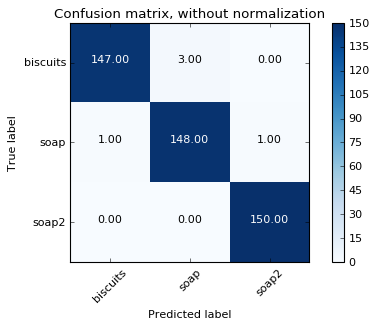

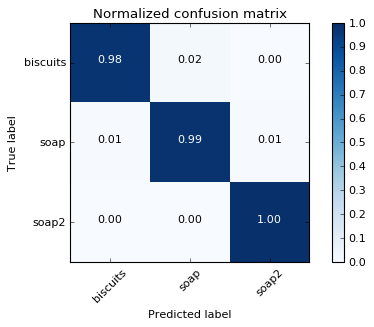

In [35]:
train_set, labels = [], []
#classes = ['biscuits','soap', 'soap2', 'glue', 'book', 'sticky_notes', 'snacks', 'eraser']
classes = ['biscuits','soap', 'soap2']
this_dataset = filter_train(classes=classes)
for cloud, norm, label in this_dataset:
    train_set.append(extract_features(cloud, norm))
    labels.append(label)
clf, encoder, scaler, x_train = train_svm('svm_model_1', train_set, labels)

In [4]:
features = pickle.load(open('./feature_dump.sav', 'rb'))

In [24]:
def predict_example(example):
    ret = scaler.transform(example.reshape(1, -1))
    return encoder.inverse_transform(clf.predict(ret))

In [25]:
idx = 50
print predict_example(train_set[idx])[0], labels[idx]

biscuits biscuits


In [29]:
print predict_example(features[3])

['soap2']


In [18]:
print len(train_set)

1200


In [17]:
dataset[3][0][:, 3:]

array([[ 102.,  100.,   51.],
       [ 109.,  107.,   50.],
       [ 152.,  149.,   89.],
       ..., 
       [ 170.,  161.,    5.],
       [ 201.,  190.,    3.],
       [ 222.,  210.,    0.]])